In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(16, 4.2)

from util import util_ctrp as util
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score


# Click-Through Rate Prediction

Problem and Data

## Click-Through Rate Prediction

**Let's consider an automatic recommendation problem**

* Given a set of restaurant indexed on a a web platform (think Tripadvisor)
* ...We want to estimate how likely a user is to actually open the restaurant card

This is know as _click-through rate_

<center><img src="assets/la-montanara.jpg" width=40%/></center>

This example (and the approach) is based on this [TensorFlow Lattice Tutorail](https://www.tensorflow.org/lattice/tutorials/shape_constraints)

## Loading the Data

**We are going to use a synthetic dataset for this use case**

In [2]:
tr, val, ts = util.load_restaurant_data()
dt_in = tr.columns[:-1]
tr.iloc[:4]

,avg_rating,num_reviews,dollar_rating,clicked
0,3.927976,122.0,DDDD,1
1,3.927976,122.0,DDDD,0
2,3.927976,122.0,DDDD,0
3,4.329771,122.0,DDDD,1


* `avg_rating` is the average rating of the reviews for this restaurant
* `num_reviews` is the number of said reviews
* `dollar_rating` tells us how expensive the restaurant is
* `clicked` tells use whether a use actually click on the card, when it was displayed

## Data Distribution

**Let's check the attribute distribution _on the training set_**

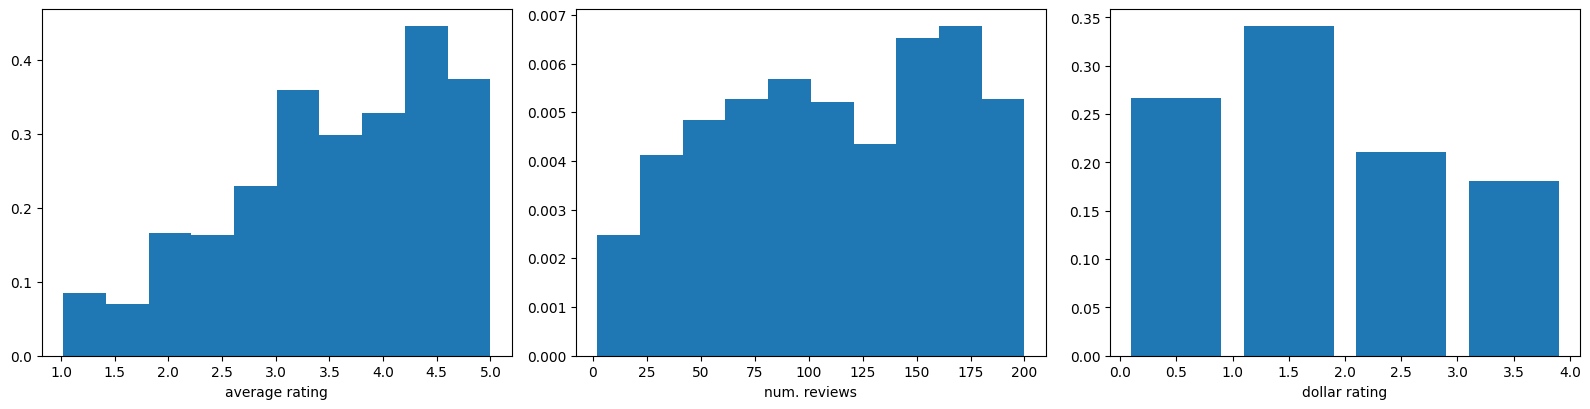

In [3]:
util.plot_ctr_distribution(tr, figsize=figsize, nbins=10)

* Most restaurants in our dataset have a good rating
* The number of review is close to unifor
* Most restaurants are in the mid-low tier in terms of price

## Data Distribution

**...Then on a second dataset, that we are going to use for _testing_**

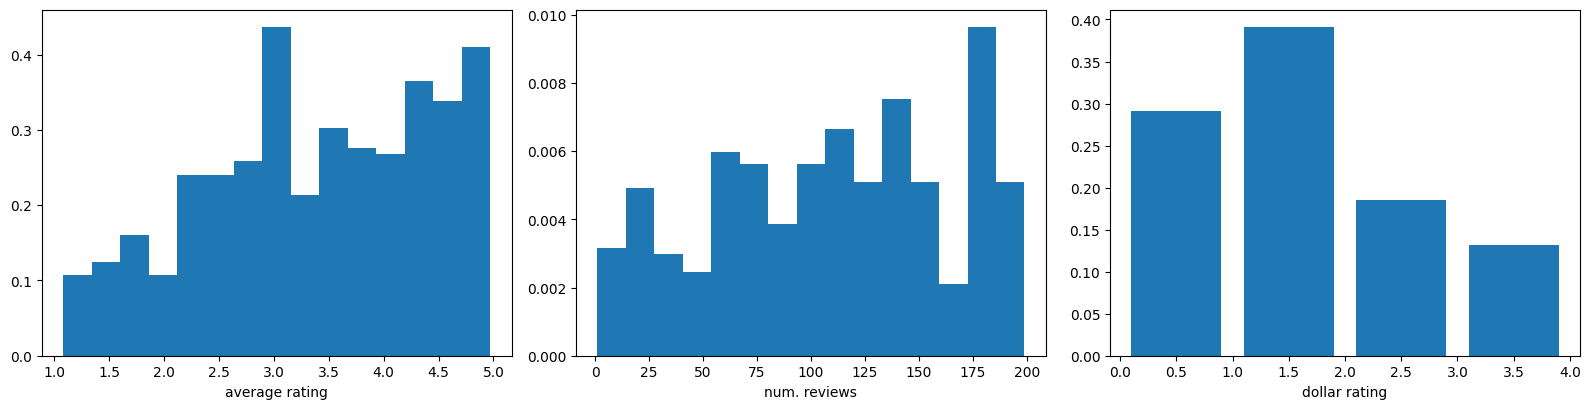

In [4]:
util.plot_ctr_distribution(val, figsize=figsize)

* In truth, this dataset is mean to be a _validation set_
* ...But for now we are going to _treat it as a test set_
* We will revisit this use case later in the course and understand the reason

## Loading the Data

**Not all users have the same preferences**

...So, when presented with the same restaurant may make opposite decisions:

In [5]:
tr[(tr[dt_in] == tr.iloc[4][dt_in]).all(axis=1)]

,avg_rating,num_reviews,dollar_rating,clicked
4,3.099026,118.0,DD,0
5,3.099026,118.0,DD,1
6,3.099026,118.0,DD,1
7,3.099026,118.0,DD,1
8,3.099026,118.0,DD,1


* Every row corresponts to a restaurant visualization event
* ...And, therefore, many input vectors in the dataset are _duplicated_
* The `clicked` column may be either 1 or 0 in these cases

**Formally, we are studying a _stochastic_ process**

## Target Function

**However, what we want to learn is the probability of a click**

We know exactly how that changes, since we are working with synthetic data

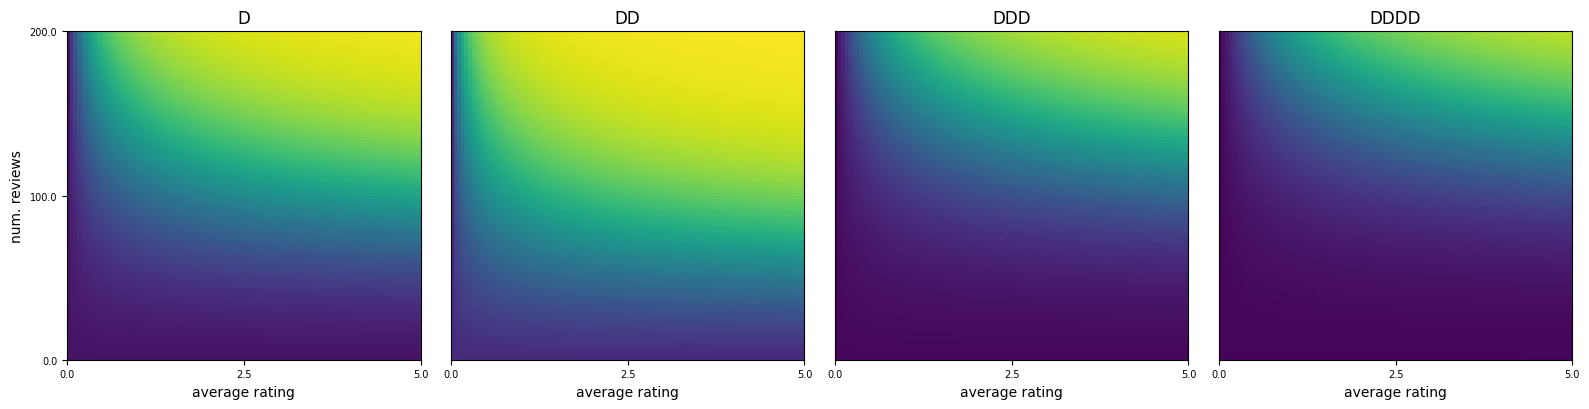

In [6]:
util.plot_ctr_truth(figsize=figsize)

**...But of course we'll pretend we don't have this information**

# Click-Through Rate Prediction

### Problem Formalization

## A System Model

**Let's start by modeling the system**

We can view both the restaurant information an the clicks as random variables:

* $X$, representing the restaurant information
* $Y$, representing the act of clicking ($1=$ click, $0=$ no click)

**The two variables are related**

We can model this formally via their joint distribution:

$$X, Y \sim P(X, Y)$$

**We want to learn the probability of clicking, given observed restaurant information**

In other words, the conditional probability:

$$P(Y \mid X)$$

## Our Data

**Our training data consists of a collection of examples $\{x_i, y_i\}_{i=1}^m$**

* $x_i$ is the restaurant data for on visualization event
* $y_i = 1$ if the user clicked, and $0$ otherwise

**Say that we try to learn an approximatation $\hat{f}(x; \theta)$ for $P(Y \mid X)$**

In this case, training for maximum likelihood estimation means solving:

$$\mathop{\rm argmax}_{\theta} \prod_{i=1}^m y_i \hat{f}(x_i; \theta) + (1-y_i) (1 - \hat{f}(x_i; \theta))$$

* The estimated probability should be high in case of clicks (i.e. $y_i=1$)
* ...And low in case of non-clicks (i.e. $1-y_i$)

**This is (almost) exactly how most _classifiers_ are trained**

<div class="big">
    <small>With most types of ML techniques...</small><br>
    When you train a classifier<br>
    ...You are actually training a probabilistic model
</div>

# Click-Through Rate Prediction

### A Solution Approach

## Preparing the Data

**We will start by tackling the problem using a Multi Layer Perceptron**

We normalize the numeric data:

In [7]:
nf = ['avg_rating', 'num_reviews']
scale = tr[nf].max()
tr_s = tr.copy()
tr_s[nf] = tr_s[nf] / scale
val_s = val.copy()
val_s[nf] = val_s[nf] / scale
ts_s = ts.copy()
ts_s[nf] = ts_s[nf] / scale

We also adopt a one-hot encoding for the categorical data:

In [8]:
tr_sc = pd.get_dummies(tr_s).astype(np.float32)
val_sc = pd.get_dummies(val_s).astype(np.float32)
ts_sc = pd.get_dummies(ts_s).astype(np.float32)
dt_in_c = [c for c in tr_sc.columns if c != 'clicked']

## Preparing the Data

**Here is the result of our preparation**

In [9]:
tr_sc

,avg_rating,num_reviews,clicked,dollar_rating_D,dollar_rating_DD,dollar_rating_DDD,dollar_rating_DDDD
0,0.785773,0.610,1.0,0.0,0.0,0.0,1.0
1,0.785773,0.610,0.0,0.0,0.0,0.0,1.0
2,0.785773,0.610,0.0,0.0,0.0,0.0,1.0
3,0.866150,0.610,1.0,0.0,0.0,0.0,1.0
4,0.619945,0.590,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
830,0.597304,0.055,1.0,0.0,1.0,0.0,0.0
831,0.783784,0.505,1.0,1.0,0.0,0.0,0.0
832,0.783784,0.505,1.0,1.0,0.0,0.0,0.0
833,0.688336,0.270,1.0,0.0,1.0,0.0,0.0


## Building a Baseline Model

**Our model will be a simple Neural Network**

In particular we will use a small deep network

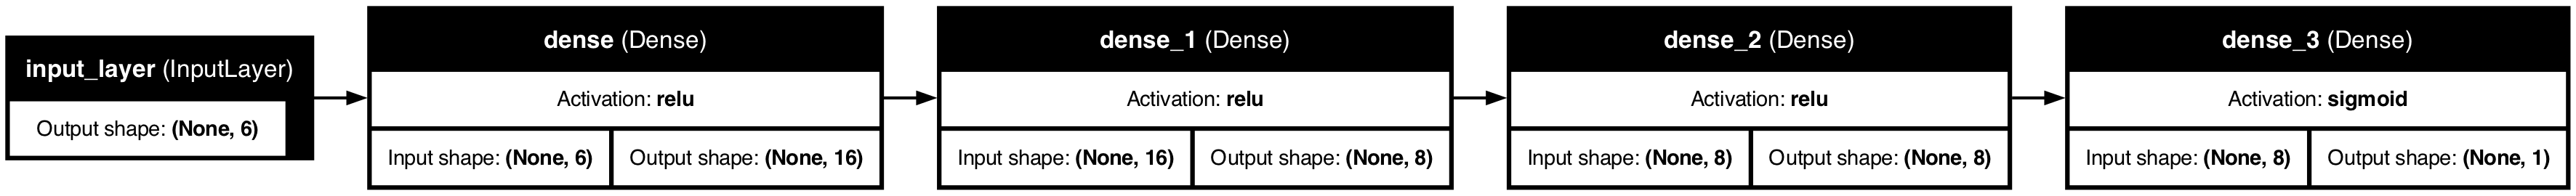

In [10]:
nn2 = util.build_nn_model(input_shape=(len(dt_in_c),), output_shape=1, hidden=[16, 8, 8], output_activation='sigmoid')
util.plot_nn_model(nn2, dpi=150)

## Training the Baseline Model

**We'll train the model to convergence**

In [11]:
nn2 = util.build_nn_model(input_shape=(len(dt_in_c),), output_shape=1, hidden=[16, 8, 8], output_activation='sigmoid')
history = util.train_nn_model(nn2, tr_sc[dt_in_c], tr_sc['clicked'], loss='binary_crossentropy', batch_size=32, epochs=100)
util.plot_training_history(history, figsize=(figsize[0], 0.5 * figsize[1]), display_loss_curve=False)

Final loss: 0.5006 (training)


* More shallow models require more training iterations to reach convergence via gradient descent
* On the other hand, deeper models require more computational effort per evaluation

## Evaluating the Predictions

**This is not a classification problem, so _accuracy is not a good metric_**

* The output of our system is _meant to be interpreted as a probability_
* ...So, rounding to obtain a deterministic prediction may be too restrictive

**Instead, we will make a first evaluation using a _ROC curve_**

A Receiver Operating Characteristic curve is a type of plot

* We consider multiple threshold values
  - Each threshold is meant to be used for discriminating between classes
  - The usual rounding approach is equivalent to a 0.5 threshold
* On the $x$ axis, we report the false positive rate for each threshold
* On the $y$ axis, we report the true positive rate for each threshold

## Evaluating the Predictions

**A ROC curve looks like this** (image from wikipedia)

<center><img src="assets/Roccurves.png" width=35%/></center>

* The large the Area Under Curve (AUC), the better the performance
* The AUC value is guaranteed to be in the $[0, 1]$ interval

## Evaluating the Predictions

**Let's compute the AUC values for the two sets we are focusing on**

In [12]:
pred_tr2 = nn2.predict(tr_sc[dt_in_c], verbose=0)
pred_val2 = nn2.predict(val_sc[dt_in_c], verbose=0)
auc_tr2 = roc_auc_score(tr_sc['clicked'], pred_tr2)
auc_val2 = roc_auc_score(val_sc['clicked'], pred_val2)
print(f'AUC score for the deeper NN: {auc_tr2:.2f} (training), {auc_val2:.2f} (test)')

AUC score for the deeper NN: 0.81 (training), 0.80 (test)


* The model works reasonably well on both the training and the test data

## Checking the Learned Response Surfaces

**Here we have again _the ground truth_ for our click rate**

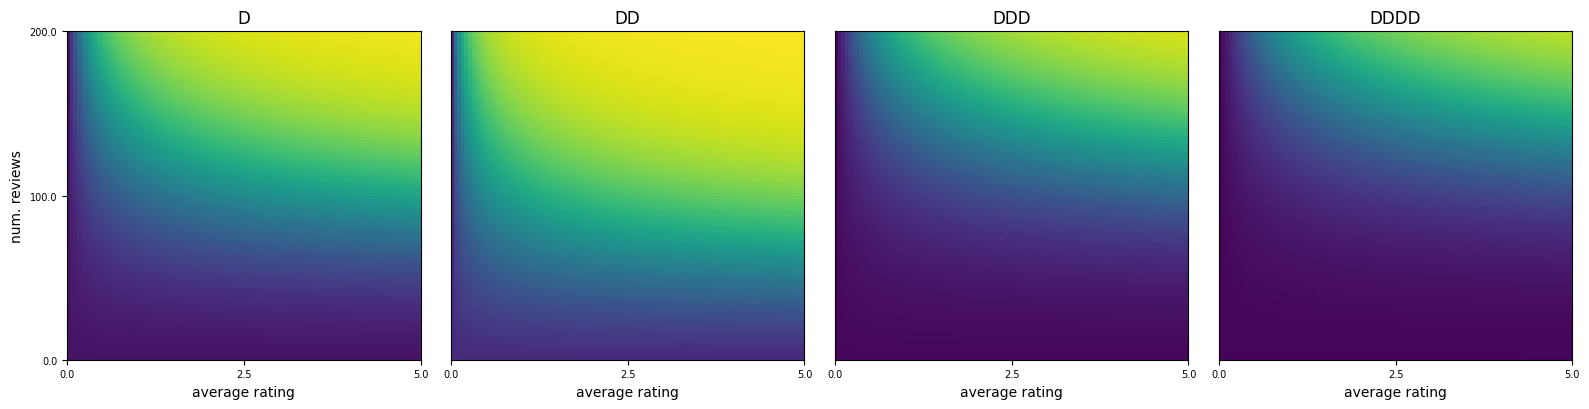

In [13]:
util.plot_ctr_truth(figsize=figsize)

## Checking the Learned Response Surfaces

**Here is the full response surface for the _deeper NN_**

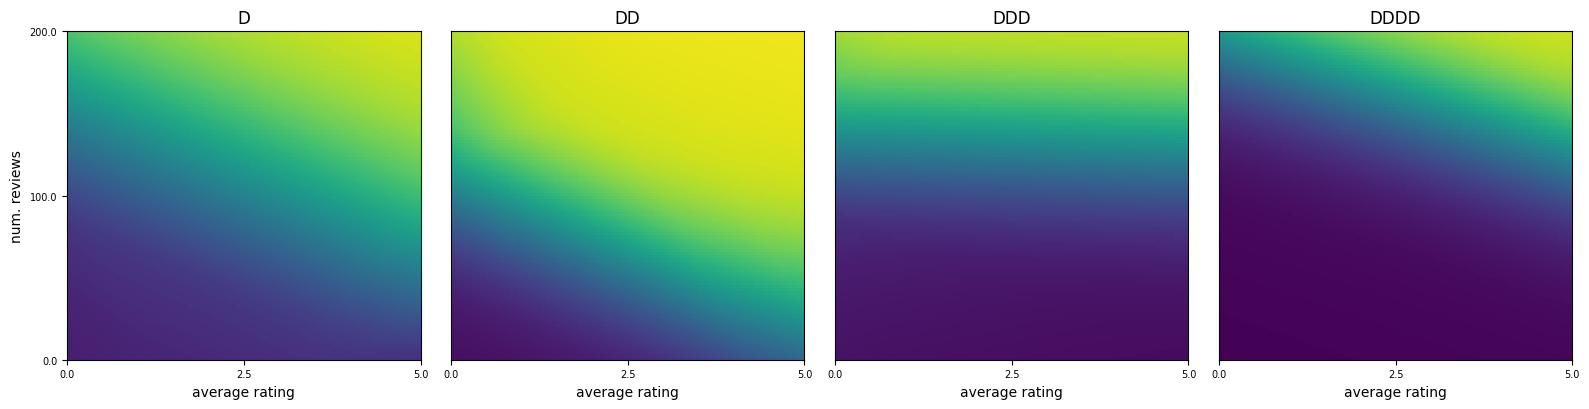

In [14]:
util.plot_ctr_estimation(nn2, scale, figsize=figsize)